## Goal: 
* Take sidewalk data .shp file and street polygon data .shp file
* Group the sidewalks by their corresponding plygons
* Clean each group


## Cleaning code:

In [1]:
import shapely
from shapely.geometry import Point, Polygon, LineString
from copy import deepcopy

def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = (avgX, avgY)
                lineAfterList[1][j] = (avgX, avgY)
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = (intrsct.x, intrsct.y)
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = (intrsct.x, intrsct.y)
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    else:
        return connectToAvgIfCloseEnough(lines, tolClose)

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean

## Plotting code:

In [2]:
import shapely 
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

## Read street polygon data and put it into a list:
* streetPolyList = [ [ [polygon0], id ], [ [polygon1], id ], ...]

In [3]:
import fiona
def putStPolygonDataintoList(streetfile):
    with fiona.open(streetfile, 'r') as inputfile:
        streetPolyList = []
        # streetPolygonList = [ [[polygon0], id], [[polygon1], id], ...]
        for row in inputfile:
            streetPolyList.append([ row['geometry']['coordinates'][0], int(row['id']) ])
        return streetPolyList

In [4]:
streetPolygonList = putStPolygonDataintoList('./20150723-postgispolygons-from-streets/20150723-postgispolygons-from-streets.shp')
print streetPolygonList[10]

[[(1270054.0493293256, 243203.10622107983), (1270066.345009327, 243628.93610951304), (1270360.594481632, 243620.9056455046), (1270348.2708976269, 243195.1315650791), (1270054.0493293256, 243203.10622107983)], 10]


## Read the SideWalk data and classify them by their corresponding polygons
* sidewalksWhichPolygon = [ [ polygonid0, [L00, L01, L02,...] ], [ polygonid1, [L10, L11, L12,...] ],...  ]

In [5]:
import fiona
def classifySideWalksByStreetPolygons(sidewalkfile, streetfile):
    StPolyList = putStPolygonDataintoList(streetfile)
    sidewalksWhichPolygon = [ [polygoninfo[1]] for polygoninfo in StPolyList]
    with fiona.open(sidewalkfile, 'r') as inputfile:  
        for row in inputfile:
            line = row['geometry']['coordinates']
            for polygoninfo in streetPolygonList:
                if Polygon(polygoninfo[0]).contains(Point(line[0])) and Polygon(polygoninfo[0]).contains(Point(line[-1])):
                    sidewalksWhichPolygon[polygoninfo[1]].append(line)
                    continue
        return sidewalksWhichPolygon

In [6]:
stFile = './20150723-postgispolygons-from-streets/20150723-postgispolygons-from-streets.shp'
swFile = './2015-07-23_SideWalk_Subset/2015-07-23_SideWalk_Subset.shp'
sideWalkClassified =  classifySideWalksByStreetPolygons(swFile,stFile)
print sideWalkClassified[0]

[0, [(1270356.8095961362, 242781.61167496443), (1270368.3581294715, 243180.57478779554)], [(1270621.5006678104, 242766.31380529702), (1270632.4885067195, 243158.00724762678)], [(1270360.6754020602, 243174.28641454875), (1270616.9232491404, 243167.31661221385), (1270631.496710807, 243159.69326788187)], [(1270350.097011149, 242791.00896587968), (1270628.8986188918, 242776.00013762712)]]


## Function:
*  Take sidewalk data and its corresponding street polygon data
*  Group the sidewalks by their corresponding plygons
*  Clean each group
*  return the cleaned version in a list: cleanList = [[id0, [L00, L01, ...] ], [id1, [L10, L11,...] ], ...]

In [7]:
def ClassAndClean(SWFile, STFile, extL, tolInt, tolClose):
    SWClassified = classifySideWalksByStreetPolygons(SWFile,STFile)
    # cleanList = [[id0, [L00, L01, ...] ], [id1, [L10, L11,...] ], ...]
    cleanList = []
    for i in range(len(SWClassified)):
        cleanList.append([SWClassified[i][0]])
        if len(SWClassified[i]) > 1:
            cleanList[i].append(cleanEachGroup(SWClassified[i][1:], extL, tolInt, tolClose))
    return cleanList

#### Read sidewalk data and put it into a list: (This func is only for having sidewalk data in a list and it is not used in the ClassAndClean code)
* sidewalkList = [ [L0], [L1], ... ]

In [8]:
import fiona
def putSideWalkDataintoList(sidewalkfile):
    with fiona.open(sidewalkfile, 'r') as inputfile:
        swList = []
        # sidewalkLineList = [ [line0], [line1], ... ]     
        for row in inputfile:
            swList.append(row['geometry']['coordinates'])
        return swList 

In [9]:
sideWalkLineList = putSideWalkDataintoList('./2015-07-23_SideWalk_Subset/2015-07-23_SideWalk_Subset.shp')
print sideWalkLineList[0]

[(1272335.6996672302, 245282.78121329844), (1272340.9804965556, 245463.79167805612)]


## Visualize the sidewalk data together with street polygon data:

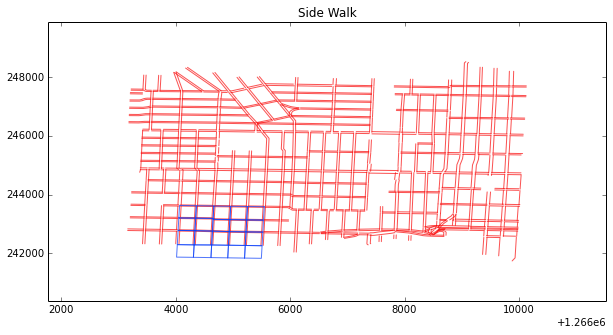

In [10]:
from shapely.geometry import LineString, Polygon, Point
from matplotlib import pyplot
%matplotlib inline

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(111)
for line in sideWalkLineList:
    plot_line(ax, line, "#F90A0A")
for polygoninfo in streetPolygonList:
    plot_line(ax, polygoninfo[0], "#0A3EF9")
handle_axesLimTitle_for_lineList(ax, sideWalkLineList, "Side Walk")
pyplot.show()     

## Main code:

In [11]:
swFile = './2015-07-23_SideWalk_Subset/2015-07-23_SideWalk_Subset.shp'
stFile = './20150723-postgispolygons-from-streets/20150723-postgispolygons-from-streets.shp'

extL, tolInt, tolClose = 1000, 25, 10 
SWClassified = classifySideWalksByStreetPolygons(swFile, stFile)
SWcleanClassified = ClassAndClean(swFile, stFile, extL, tolInt, tolClose)

## Plot the results

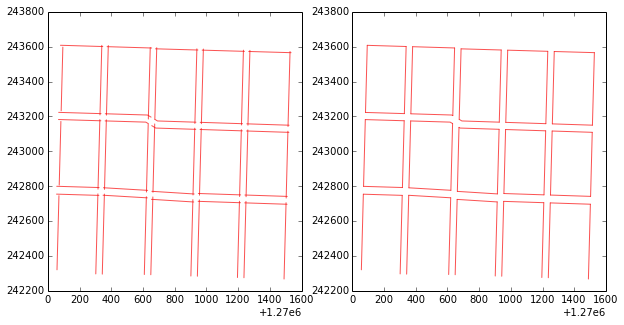

In [12]:
# Plot the results of Main Code
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for group in SWClassified:
    for i in range(1, len(group)):
        plot_line(ax, group[i], "#F90A0A")
# handle_axesLimTitle_for_lineList(ax, sidewalkLineList, "Side Walk")
ax = fig.add_subplot(122)
for group in SWcleanClassified:
    if len(group) > 1:
        for line in group[1]:
            plot_line(ax, line, "#F90A0A")
# handle_axesLimTitle_for_lineList(ax, sidewalkLineList, "Side Walk")
pyplot.show()  

## Code:

In [13]:
# Packages:

import shapely
from shapely.geometry import Point, Polygon, LineString
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()
# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = (avgX, avgY)
                lineAfterList[1][j] = (avgX, avgY)
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = (intrsct.x, intrsct.y)
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = (intrsct.x, intrsct.y)
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    else:
        return connectToAvgIfCloseEnough(lines, tolClose)

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean

# Classify sidewalks by corresponding street polygons and clean them:
def putStPolygonDataintoList(streetfile):
    with fiona.open(streetfile, 'r') as inputfile:
        streetPolyList = []
        # streetPolygonList = [ [[polygon0], id], [[polygon1], id], ...]
        for row in inputfile:
            streetPolyList.append([ row['geometry']['coordinates'][0], int(row['id']) ])
        return streetPolyList


def classifySideWalksByStreetPolygons(sidewalkfile, streetfile):
    StPolyList = putStPolygonDataintoList(streetfile)
    sidewalksWhichPolygon = [ [polygoninfo[1]] for polygoninfo in StPolyList]
    with fiona.open(sidewalkfile, 'r') as inputfile:  
        for row in inputfile:
            line = row['geometry']['coordinates']
            for polygoninfo in StPolyList:
                if Polygon(polygoninfo[0]).contains(Point(line[0])) and Polygon(polygoninfo[0]).contains(Point(line[-1])):
                    sidewalksWhichPolygon[polygoninfo[1]].append(line)
                    continue
        return sidewalksWhichPolygon
def ClassAndClean(SWFile, STFile, extL, tolInt, tolClose):
    SWClassified = classifySideWalksByStreetPolygons(SWFile,STFile)
    # cleanList = [[id0, [L00, L01, ...] ], [id1, [L10, L11,...] ], ...]
    cleanList = []
    for i in range(len(SWClassified)):
        cleanList.append([SWClassified[i][0]])
        if len(SWClassified[i]) > 1:
            cleanList[i].append(cleanEachGroup(SWClassified[i][1:], extL, tolInt, tolClose))
    return cleanList

# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

## Main code:

In [14]:
swFile = './2015-07-23_SideWalk_Subset/2015-07-23_SideWalk_Subset.shp'
stFile = './20150723-postgispolygons-from-streets/20150723-postgispolygons-from-streets.shp'

extL, tolInt, tolClose = 1000, 25, 10 
SWClassified = classifySideWalksByStreetPolygons(swFile, stFile)
SWcleanClassified = ClassAndClean(swFile, stFile, extL, tolInt, tolClose)

## Plot the results:

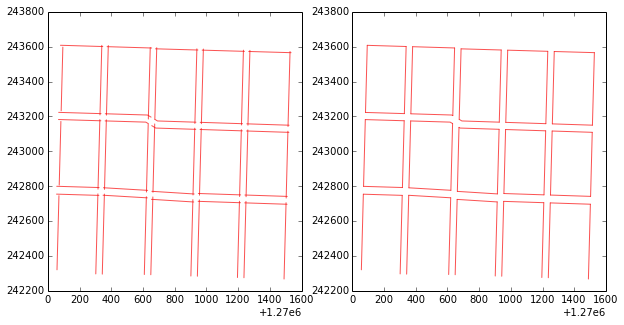

In [15]:
# Plot the results of Main Code
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for group in SWClassified:
    for i in range(1, len(group)):
        plot_line(ax, group[i], "#F90A0A")
# handle_axesLimTitle_for_lineList(ax, sidewalkLineList, "Side Walk")
ax = fig.add_subplot(122)
for group in SWcleanClassified:
    if len(group) > 1:
        for line in group[1]:
            plot_line(ax, line, "#F90A0A")
# handle_axesLimTitle_for_lineList(ax, sidewalkLineList, "Side Walk")
pyplot.show()  